# AuxTel - M1 Mirror Motion - Closed Dome Tests
by Patrick Ingraham, modified by Bruno Quint.

This notebooks looks at primary mirror motion as a function of elevation. This is used verify the mirror doesn't lift when we go below the LUT. Data obtained mainly on 2021-08-17.

## Import Libraries

In [1]:
import asyncio 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from astropy.time import Time, TimeDelta
from IPython.display import FileLink, FileLinks
from lsst_efd_client import EfdClient, rendezvous_dataframes

%matplotlib inline

## Set up Logger

In [2]:
import logging
from lsst.ts.observing.utilities.decorated_logger import DecoratedLogger

logger = DecoratedLogger.get_decorated_logger()
logger.level = logging.DEBUG

logging.getLogger("matplotlib").level = logging.INFO

ModuleNotFoundError: No module named 'lsst.ts'

## Set up EFD Client

In [3]:
efd_client = EfdClient('summit_efd')
#efd_client = EfdClient('ldf_stable_efd') 

  [D 2021-08-25 22:00:03 urllib3.connectionpool]  Starting new HTTPS connection (1): roundtable.lsst.codes:443
  [D 2021-08-25 22:00:04 urllib3.connectionpool]  https://roundtable.lsst.codes:443 "GET /segwarides/ HTTP/1.1" 200 253
  [D 2021-08-25 22:00:04 urllib3.connectionpool]  Starting new HTTPS connection (1): roundtable.lsst.codes:443
  [D 2021-08-25 22:00:04 urllib3.connectionpool]  https://roundtable.lsst.codes:443 "GET /segwarides/creds/summit_efd HTTP/1.1" 200 160
  [D 2021-08-25 22:00:04 urllib3.connectionpool]  Starting new HTTPS connection (1): influxdb-summit-efd.lsst.codes:443
  [D 2021-08-25 22:00:05 urllib3.connectionpool]  https://influxdb-summit-efd.lsst.codes:443 "GET /health HTTP/1.1" 200 106


Query for all the `endReadout` events on the timespan of the night, elevation, and pmd data

## Set up time range

In [55]:
date = '20210819'
test = 'verify_no_lift_at_low_elev'
run = 'test4'

# Starting Nominal LUT from m1_hex_20210810_v3.yaml:v0.8.2.alpha.2-0-g72c6e32, low elevation test
# start time is 2021-08-17T17:36:43.64
if run == 'test1': 
    t1 = Time("2021-08-17T17:36:45", format='isot', scale='tai')
    t2 = Time("2021-08-17T17:45:00.386", format='isot', scale='tai')
    scale_factor=1.0
    start_log_msg = '[2021-07-08_Repeat_Focus_Test_START]'
    finish_log_msg = '[2021-07-08_Repeat_Focus_Test_END]'

# Starting Nominal LUT from m1_hex_20210810_v3.yaml:v0.8.2.alpha.2-0-g72c6e32, low elevation test
# start time is 2021-08-17T18:52:18.40
elif run == 'test2':
    t1 = Time("2021-08-17T18:52:18.40", format='isot', scale='tai')
    t2 = Time("2021-08-17T18:58:41.773", format='isot', scale='tai')

# Starting Test3, Nominal LUT from m1_hex_20210810_v3.yaml:v0.8.2.alpha.2-0-g72c6e32, low elevation test, minimum adjusted higher
# start time is 2021-08-17T19:13:07.588
elif run == 'test3':
    t1 = Time("2021-08-17T19:13:07.588", format='isot', scale='tai')
    t2 = Time("2021-08-17T19:18:50.310", format='isot', scale='tai') 

# Starting Nominal LUT from m1_hex_20210810_v3.yaml:v0.8.2.alpha.2-0-g72c6e32, low elevation test
# start time is 2021-08-17T17:36:43.64
elif run == 'test4':
    t1 = Time("2021-08-17T20:45:16.148", format='isot', scale='tai')
    t2 = Time("2021-08-17T20:50:39.174", format='isot', scale='tai') 

#Starting Test16, Nominal LUT from m1_hex_20210810_v3.yaml:v0.8.2.alpha.2-0-g72c6e32, low elevation test ED
elif run == 'test5':
    t1 = Time("2021-08-19T23:21:30.379", format='isot', scale='tai')
    t2 = Time("2021-08-19T23:25:59.912", format='isot', scale='tai')

#ATAOS on, but with 45K PA limit
elif run == 'test6':
    t1 = Time("2021-08-19T23:48:18.697", format='isot', scale='tai')
    t2 = Time("2021-08-19T23:51:54.218", format='isot', scale='tai')

else:
    raise IOError('Not a valid input')

In [56]:
# # # day of 2021-07-08 - Test3 run with scalefactor = 1.02  - not sure this was great, so redid it
# t1 = Time("2021-08-09T16:42:32.166", format='isot', scale='tai')
# t2 = Time("2021-08-09T16:48:41.015", format='isot', scale='tai')

In [57]:
# # # day of 2021-07-08 - Test4 run with scalefactor = 1.04 - ignore, redoing
# t1 = Time("2021-08-09T16:50:24.872", format='isot', scale='tai')
# t2 = Time("2021-08-09T16:59:24.872", format='isot', scale='tai')

In [58]:
# # day of 2021-07-08 - Test4 (didn't increment) run with scalefactor = 1.06 = BAD - Sensor dropped out
# t1 = Time("2021-08-09T16:59:24.872", format='isot', scale='tai')
# t2 = Time("2021-08-09T17:05:32.895", format='isot', scale='tai')

## Querying log messages

In [59]:
df_log_message = await efd_client.select_time_series(
    "lsst.sal.Script.logevent_logMessage", ["message","level"], t1, t2)

df_log_message

  [D 2021-08-25 22:02:44 aioinflux]  200: SELECT message, level FROM "efd"."autogen"."lsst.sal.Script.logevent_logMessage" WHERE time >= '2021-08-17T20:45:16.148Z' AND time <= '2021-08-17T20:50:39.174Z'


,message,level
2021-08-17 20:45:27.648000+00:00,"az,el,pos0,pos1,pos2 = 0, 83, -0.181, -0.012, ...",20
2021-08-17 20:45:47.647000+00:00,"az,el,pos0,pos1,pos2 = 0, 76, -0.138, -0.006, ...",20
2021-08-17 20:46:09.069000+00:00,"az,el,pos0,pos1,pos2 = 0, 69, -0.088, 0.021, 0...",20
2021-08-17 20:46:30.490000+00:00,"az,el,pos0,pos1,pos2 = 0, 62, -0.052, 0.044, 0...",20
2021-08-17 20:46:50.112000+00:00,"az,el,pos0,pos1,pos2 = 0, 55, -0.02, 0.062, 0....",20
2021-08-17 20:47:11.437000+00:00,"az,el,pos0,pos1,pos2 = 0, 48, 0.006, 0.078, 0....",20
2021-08-17 20:47:31.434000+00:00,"az,el,pos0,pos1,pos2 = 0, 41, 0.03, 0.09, 0.08...",20
2021-08-17 20:47:51.053000+00:00,"az,el,pos0,pos1,pos2 = 0, 34, 0.05, 0.101, 0.0...",20
2021-08-17 20:48:10.676000+00:00,"az,el,pos0,pos1,pos2 = 0, 30, 0.058, 0.106, 0....",20
2021-08-17 20:48:30.672000+00:00,"az,el,pos0,pos1,pos2 = 0, 37, 0.056, 0.105, 0....",20


## Query Elevation

In [60]:
df_elevation = await efd_client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", ["elevationCalculatedAngle1", ], t1, t2)

# mount reporting incorrect timestamp for the packed time series
df_elevation.index = df_elevation.index + pd.tseries.offsets.DateOffset(seconds=-37)
df_elevation.index = pd.to_datetime(df_elevation.index).tz_localize('Etc/UCT')
df_elevation = df_elevation.resample('1s').median()

  [D 2021-08-25 22:02:45 aioinflux]  200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"
  [D 2021-08-25 22:02:45 aioinflux]  200: SELECT elevationCalculatedAngle10, elevationCalculatedAngle11, elevationCalculatedAngle12, elevationCalculatedAngle13, elevationCalculatedAngle14, elevationCalculatedAngle15, elevationCalculatedAngle16, elevationCalculatedAngle17, elevationCalculatedAngle18, elevationCalculatedAngle19, cRIO_timestamp FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders" WHERE time >= '2021-08-17T20:45:16.148Z' AND time <= '2021-08-17T20:50:39.174Z'


In [61]:
df_elevation

,elevationCalculatedAngle1,times
2021-08-17 20:45:14+00:00,82.998024,1.629233e+09
2021-08-17 20:45:15+00:00,82.998025,1.629233e+09
2021-08-17 20:45:16+00:00,82.998024,1.629233e+09
2021-08-17 20:45:17+00:00,82.998025,1.629233e+09
2021-08-17 20:45:18+00:00,82.998025,1.629233e+09
...,...,...
2021-08-17 20:50:32+00:00,79.000099,1.629233e+09
2021-08-17 20:50:33+00:00,79.000090,1.629233e+09
2021-08-17 20:50:34+00:00,79.000077,1.629233e+09
2021-08-17 20:50:35+00:00,79.000064,1.629233e+09


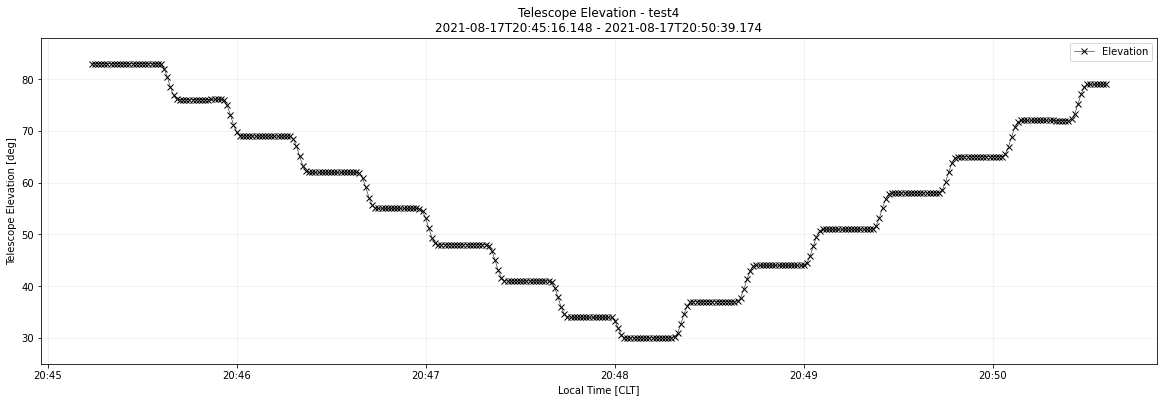

In [62]:
%matplotlib inline
fig, ax = plt.subplots(num='Elevation', figsize=(20, 6))

ax.plot(df_elevation.index, df_elevation['elevationCalculatedAngle1'], 
        'kx-', label='Elevation', lw=0.5)

ax.set_ylim(df_elevation['elevationCalculatedAngle1'].min() - 5, 
            df_elevation['elevationCalculatedAngle1'].max() + 5)

ax.grid('-', alpha=0.2)
ax.set_xlabel('Local Time [CLT]')
ax.set_ylabel('Telescope Elevation [deg]')
ax.legend()
ax.set_title(f'Telescope Elevation - {run}\n{t1} - {t2}')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()

## Query PMD

Precision Measurement Devices - these are the Mitutoyo Micrometers.

In [63]:
df_pmd = await efd_client.select_time_series(
    "lsst.sal.PMD.position", 
    ["position0", "position1", "position2", "position3", "position5"], t1, t2)

# We are only insterested in relative values
df_pmd = df_pmd - df_pmd.iloc[0]
# df_pmd = df_pmd.resample('1s').median().interpolate(method='polynomial', order=1)

  [D 2021-08-25 22:02:48 aioinflux]  200: SELECT position0, position1, position2, position3, position5 FROM "efd"."autogen"."lsst.sal.PMD.position" WHERE time >= '2021-08-17T20:45:16.148Z' AND time <= '2021-08-17T20:50:39.174Z'


In [64]:
df_pmd

,position0,position1,position2,position3,position5
2021-08-17 20:45:16.745000+00:00,0.000,0.000,0.000,0.000,0.000
2021-08-17 20:45:18.641000+00:00,0.000,0.000,0.000,0.000,0.000
2021-08-17 20:45:20.441000+00:00,0.000,0.000,0.000,0.000,0.000
2021-08-17 20:45:22.243000+00:00,0.000,0.000,0.000,0.000,0.000
2021-08-17 20:45:24.138000+00:00,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...
2021-08-17 20:50:31.146000+00:00,0.073,0.019,-0.002,-0.002,0.008
2021-08-17 20:50:32.947000+00:00,0.071,0.019,-0.001,-0.002,0.005
2021-08-17 20:50:34.654000+00:00,0.070,0.019,0.000,-0.001,0.005
2021-08-17 20:50:36.454000+00:00,0.069,0.019,0.000,-0.001,0.004


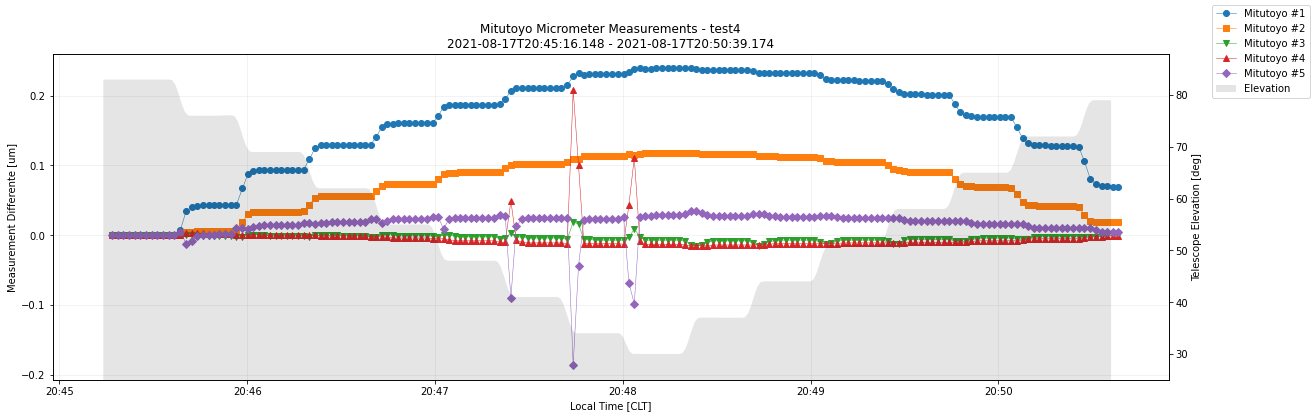

In [65]:
%matplotlib inline
fig, ax = plt.subplots(num='PMD', figsize=(20, 6))

ax.plot(df_pmd.index, df_pmd['position0'], 'C0o-', label='Mitutoyo #1', lw=0.5)
ax.plot(df_pmd.index, df_pmd['position1'], 'C1s-', label='Mitutoyo #2', lw=0.5)
ax.plot(df_pmd.index, df_pmd['position2'], 'C2v-', label='Mitutoyo #3', lw=0.5)
ax.plot(df_pmd.index, df_pmd['position3'], 'C3^-', label='Mitutoyo #4', lw=0.5)
ax.plot(df_pmd.index, df_pmd['position5'], 'C4D-', label='Mitutoyo #5', lw=0.5)

ax.grid('-', alpha=0.2)
ax.set_xlabel('Local Time [CLT]')
ax.set_ylabel('Measurement Differente [um]')
ax.set_title(f'Mitutoyo Micrometer Measurements - {run}\n{t1} - {t2}')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2 = ax.twinx()
ax2.fill_between(df_elevation.index, 0, 
                df_elevation['elevationCalculatedAngle1'], zorder=-10, 
                label='Elevation', fc='black', lw=0.5, alpha=0.1)
ax2.set_ylim(df_elevation['elevationCalculatedAngle1'].min() - 5, 
            df_elevation['elevationCalculatedAngle1'].max() + 5, )
ax2.set_ylabel('Telescope Elevation [deg]')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

fig.legend()
fig.savefig(f'./plots/mit_measurements_{run}_{t1}_{t2}.png', 
            facecolor='white', edgecolor='none')
plt.show()

del fig, ax, ax2

In [66]:
FileLink(f'./mit_measurements_{run}_{t1}_{t2}.png')

/scratch/bquint/notebooks/AuxTel/mit_measurements_test4_2021-08-17T20:45:16.148_2021-08-17T20:50:39.174.png

## Query ATM1 Air Pressure

In [67]:
df_pressure = await efd_client.select_time_series(
    "lsst.sal.ATPneumatics.m1AirPressure", ["pressure"], t1, t2)
df_pressure = df_pressure.resample('1s').median()

  [D 2021-08-25 22:02:50 aioinflux]  200: SELECT pressure FROM "efd"."autogen"."lsst.sal.ATPneumatics.m1AirPressure" WHERE time >= '2021-08-17T20:45:16.148Z' AND time <= '2021-08-17T20:50:39.174Z'


In [68]:
df_pressure

,pressure
2021-08-17 20:45:17+00:00,121340.032861
2021-08-17 20:45:18+00:00,121318.991724
2021-08-17 20:45:19+00:00,121295.846472
2021-08-17 20:45:20+00:00,121340.032861
2021-08-17 20:45:21+00:00,121361.073999
...,...
2021-08-17 20:50:34+00:00,119378.998828
2021-08-17 20:50:35+00:00,119509.453882
2021-08-17 20:50:36+00:00,119530.495020
2021-08-17 20:50:37+00:00,119553.640271


In [69]:
df_atpneumatics_commands = await efd_client.select_time_series("lsst.sal.ATPneumatics.command_m1SetPressure", ["pressure"], t1, t2)
df_atpneumatics_commands = df_atpneumatics_commands.rename(columns={'pressure': 'pressure_cmd_atpneumatics'})
df_atpneumatics_commands = df_atpneumatics_commands.resample('1s').median()

  [D 2021-08-25 22:02:51 aioinflux]  200: SELECT pressure FROM "efd"."autogen"."lsst.sal.ATPneumatics.command_m1SetPressure" WHERE time >= '2021-08-17T20:45:16.148Z' AND time <= '2021-08-17T20:50:39.174Z'


In [70]:
df_atpneumatics_commands

,pressure_cmd_atpneumatics
2021-08-17 20:45:16+00:00,121905.333639
2021-08-17 20:45:17+00:00,121905.333130
2021-08-17 20:45:18+00:00,121905.332790
2021-08-17 20:45:19+00:00,121905.332790
2021-08-17 20:45:20+00:00,121905.333809
...,...
2021-08-17 20:50:31+00:00,119933.164566
2021-08-17 20:50:32+00:00,NaN
2021-08-17 20:50:33+00:00,119971.646266
2021-08-17 20:50:34+00:00,119971.644303


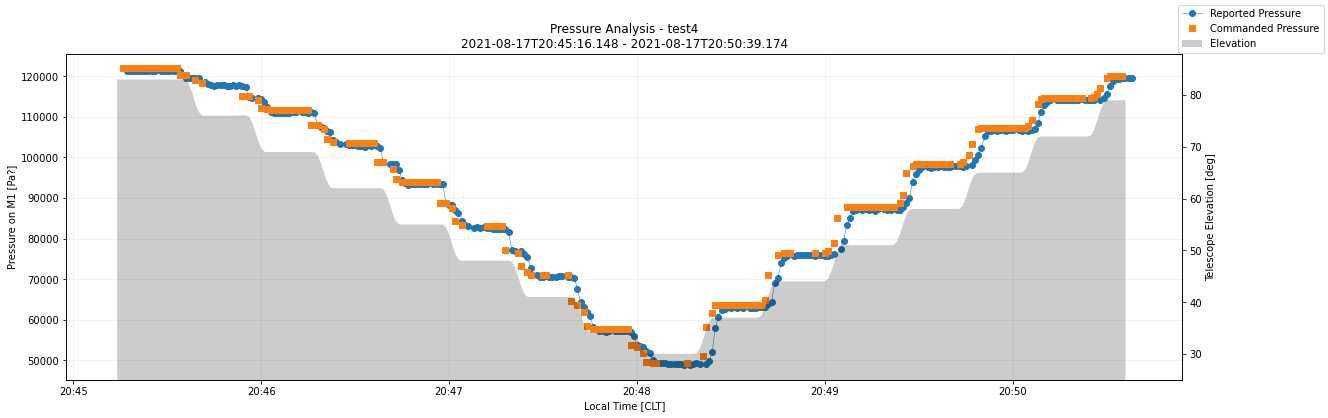

In [71]:
%matplotlib inline
fig, ax = plt.subplots(num='PMD', figsize=(20, 6))

ax.plot(df_pressure.index, df_pressure['pressure'], 'C0o-', 
        label='Reported Pressure', lw=0.5, zorder=3)
ax.plot(df_atpneumatics_commands.index, 
        df_atpneumatics_commands['pressure_cmd_atpneumatics'], 
        'C1s', label='Commanded Pressure', lw=0.5, zorder=3)
ax.grid('-', alpha=0.2)
ax.set_xlabel('Local Time [CLT]')
ax.set_ylabel('Pressure on M1 [Pa?]')
ax.set_title(f'Pressure Analysis - {run}\n{t1} - {t2}')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2 = ax.twinx()
ax2.fill_between(df_elevation.index, 0, 
                df_elevation['elevationCalculatedAngle1'], 
                label='Elevation', fc='black', lw=0.5, alpha=0.2)
ax2.set_ylim(df_elevation['elevationCalculatedAngle1'].min() - 5, 
            df_elevation['elevationCalculatedAngle1'].max() + 5, )
ax2.set_ylabel('Telescope Elevation [deg]')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

fig.legend()
fig.savefig(f'./plots/pressure_{run}_{t1}_{t2}.png', 
            facecolor='white', edgecolor='none')
plt.show()

del fig, ax, ax2

## Old Stuff

The following contents are part of the original notebook and I did not update them yet. I am keeping everything to clean it up later.

## Joining DataFrames

In [107]:
df_log_message

,message,level
2021-08-19 23:48:33.160000+00:00,"az,el,pos0,pos1,pos2 = 0, 43, -0.006, 0.136, 0...",20
2021-08-19 23:48:54.057000+00:00,"az,el,pos0,pos1,pos2 = 0, 38, 0.008, 0.144, 0....",20
2021-08-19 23:49:13.329000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.021, 0.151, 0....",20
2021-08-19 23:49:34.036000+00:00,"az,el,pos0,pos1,pos2 = 0, 28, 0.031, 0.157, 0....",20
2021-08-19 23:49:54.839000+00:00,"az,el,pos0,pos1,pos2 = 0, 23, 0.039, 0.162, 0....",20
2021-08-19 23:50:13.635000+00:00,"az,el,pos0,pos1,pos2 = 0, 18, 0.045, 0.166, 0....",20
2021-08-19 23:50:32.622000+00:00,"az,el,pos0,pos1,pos2 = 0, 23, 0.045, 0.166, 0....",20
2021-08-19 23:50:53.710000+00:00,"az,el,pos0,pos1,pos2 = 0, 28, 0.044, 0.165, 0....",20
2021-08-19 23:51:14.511000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.042, 0.163, 0....",20
2021-08-19 23:51:33.405000+00:00,"az,el,pos0,pos1,pos2 = 0, 38, 0.038, 0.161, 0....",20


In [108]:
tmp = rendezvous_dataframes(df_log_message, df_elevation)
tmp = rendezvous_dataframes(tmp, df_pmd)
tmp = rendezvous_dataframes(tmp, df_pressure)
tmp = rendezvous_dataframes(tmp, df_atpneumatics_commands)
raw_data = tmp

In [109]:
raw_data

,message,level,elevationCalculatedAngle1,times,position0,position1,position2,position3,position5,pressure,pressure_cmd_atpneumatics
2021-08-19 23:48:33.160000+00:00,"az,el,pos0,pos1,pos2 = 0, 43, -0.006, 0.136, 0...",20,42.999980,1.629417e+09,0.000,0.000,0.000,0.000,0.000,75013.759998,NaN
2021-08-19 23:48:54.057000+00:00,"az,el,pos0,pos1,pos2 = 0, 38, 0.008, 0.144, 0....",20,38.000000,1.629417e+09,0.014,0.008,0.002,-0.005,0.000,65208.589832,65571.443513
2021-08-19 23:49:13.329000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.021, 0.151, 0....",20,32.999945,1.629417e+09,0.027,0.015,0.001,-0.005,0.002,55315.046887,NaN
2021-08-19 23:49:34.036000+00:00,"az,el,pos0,pos1,pos2 = 0, 28, 0.031, 0.157, 0....",20,27.999995,1.629417e+09,0.037,0.021,-0.001,-0.006,0.004,44617.732483,NaN
2021-08-19 23:49:54.839000+00:00,"az,el,pos0,pos1,pos2 = 0, 23, 0.039, 0.162, 0....",20,22.999946,1.629417e+09,0.045,0.026,-0.004,-0.008,0.008,32914.651697,NaN
2021-08-19 23:50:13.635000+00:00,"az,el,pos0,pos1,pos2 = 0, 18, 0.045, 0.166, 0....",20,17.999930,1.629417e+09,0.051,0.030,-0.007,-0.010,0.007,NaN,NaN
2021-08-19 23:50:32.622000+00:00,"az,el,pos0,pos1,pos2 = 0, 23, 0.045, 0.166, 0....",20,23.000074,1.629417e+09,0.051,0.030,-0.008,-0.010,0.003,32468.579578,NaN
2021-08-19 23:50:53.710000+00:00,"az,el,pos0,pos1,pos2 = 0, 28, 0.044, 0.165, 0....",20,28.000032,1.629417e+09,0.050,0.029,-0.006,-0.008,0.002,44659.814758,NaN
2021-08-19 23:51:14.511000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.042, 0.163, 0....",20,33.000005,1.629417e+09,0.048,0.027,-0.005,-0.007,0.004,55348.712708,NaN
2021-08-19 23:51:33.405000+00:00,"az,el,pos0,pos1,pos2 = 0, 38, 0.038, 0.161, 0....",20,38.000062,1.629417e+09,0.044,0.025,-0.004,-0.006,0.003,64947.679724,65571.500257


In [110]:
raw_data = raw_data.drop_duplicates(
    subset=['elevationCalculatedAngle1', 'message', 'pressure'])

print(raw_data[['elevationCalculatedAngle1','pressure']])

                                  elevationCalculatedAngle1      pressure
2021-08-19 23:48:33.160000+00:00                  42.999980  75013.759998
2021-08-19 23:48:54.057000+00:00                  38.000000  65208.589832
2021-08-19 23:49:13.329000+00:00                  32.999945  55315.046887
2021-08-19 23:49:34.036000+00:00                  27.999995  44617.732483
2021-08-19 23:49:54.839000+00:00                  22.999946  32914.651697
2021-08-19 23:50:13.635000+00:00                  17.999930           NaN
2021-08-19 23:50:32.622000+00:00                  23.000074  32468.579578
2021-08-19 23:50:53.710000+00:00                  28.000032  44659.814758
2021-08-19 23:51:14.511000+00:00                  33.000005  55348.712708
2021-08-19 23:51:33.405000+00:00                  38.000062  64947.679724
2021-08-19 23:51:54.207000+00:00                  42.999972  74033.242981
2021-08-19 23:51:54.213000+00:00                  42.999972  74033.242981
2021-08-19 23:51:54.215000+00:00      

In [111]:
raw_data

,message,level,elevationCalculatedAngle1,times,position0,position1,position2,position3,position5,pressure,pressure_cmd_atpneumatics
2021-08-19 23:48:33.160000+00:00,"az,el,pos0,pos1,pos2 = 0, 43, -0.006, 0.136, 0...",20,42.999980,1.629417e+09,0.000,0.000,0.000,0.000,0.000,75013.759998,NaN
2021-08-19 23:48:54.057000+00:00,"az,el,pos0,pos1,pos2 = 0, 38, 0.008, 0.144, 0....",20,38.000000,1.629417e+09,0.014,0.008,0.002,-0.005,0.000,65208.589832,65571.443513
2021-08-19 23:49:13.329000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.021, 0.151, 0....",20,32.999945,1.629417e+09,0.027,0.015,0.001,-0.005,0.002,55315.046887,NaN
2021-08-19 23:49:34.036000+00:00,"az,el,pos0,pos1,pos2 = 0, 28, 0.031, 0.157, 0....",20,27.999995,1.629417e+09,0.037,0.021,-0.001,-0.006,0.004,44617.732483,NaN
2021-08-19 23:49:54.839000+00:00,"az,el,pos0,pos1,pos2 = 0, 23, 0.039, 0.162, 0....",20,22.999946,1.629417e+09,0.045,0.026,-0.004,-0.008,0.008,32914.651697,NaN
2021-08-19 23:50:13.635000+00:00,"az,el,pos0,pos1,pos2 = 0, 18, 0.045, 0.166, 0....",20,17.999930,1.629417e+09,0.051,0.030,-0.007,-0.010,0.007,NaN,NaN
2021-08-19 23:50:32.622000+00:00,"az,el,pos0,pos1,pos2 = 0, 23, 0.045, 0.166, 0....",20,23.000074,1.629417e+09,0.051,0.030,-0.008,-0.010,0.003,32468.579578,NaN
2021-08-19 23:50:53.710000+00:00,"az,el,pos0,pos1,pos2 = 0, 28, 0.044, 0.165, 0....",20,28.000032,1.629417e+09,0.050,0.029,-0.006,-0.008,0.002,44659.814758,NaN
2021-08-19 23:51:14.511000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.042, 0.163, 0....",20,33.000005,1.629417e+09,0.048,0.027,-0.005,-0.007,0.004,55348.712708,NaN
2021-08-19 23:51:33.405000+00:00,"az,el,pos0,pos1,pos2 = 0, 38, 0.038, 0.161, 0....",20,38.000062,1.629417e+09,0.044,0.025,-0.004,-0.006,0.003,64947.679724,65571.500257


In [113]:
# from scipy import linalg
arr_len = len(raw_data.position0)
coeff_arr = np.zeros((arr_len,3))
theta_arr = np.zeros((arr_len))
phi_arr = np.zeros((arr_len))
piston_arr = np.zeros((arr_len))
for i in np.arange(arr_len):
    # X, Y, Z
    set2=np.array((  41.0, 468.0, (raw_data.position2[i])))
    set3=np.array(( 384.0,-269.0, (raw_data.position3[i])))
    set4=np.array((-425.0,-198.0, (raw_data.position5[i])))

    # Vector PQ crossed with Vector PR
    normal = np.cross(set3-set2,set4-set2) # gives a,b,c

    D= -normal[0]*set2[0] - normal[1]*set2[1] - normal[2]*set2[2]  # Constant in plane equation
    # equation 
    
    phi_from_normal = (np.pi/2+np.arctan2(normal[2], normal[1])) * 206265
    theta_from_normal = (np.pi/2+np.arctan2(normal[2], normal[0])) * 206265
    # find z at the origin to represent piston
    Z_origin = -D/normal[2]
    
    # Measure rotation about the Y-axis (perpendicular to elevation)
    # So this is TIP and should result in motion in azimuth
    # get slope by looking at Y=0, X=400
    x_pt=400; y_pt=0
    #Z_at_x_pt= C[0]*x_pt + C[1]*0.0 + C[2]
    Z_at_x_pt= (-D - normal[0]*x_pt - normal[1]*0.0)/normal[2]
    theta = np.arctan2(Z_at_x_pt-Z_origin, x_pt) * 206265 # arcsec
        
    # Measure rotation about the X-axis (aligned to elevation)
    # this is TILT and should result in motion in elevation
    # get slope by looking at Y=0, X=400    
    x_pt=0; y_pt=400
    Z_at_y_pt= (-D - normal[0]*x_pt - normal[1]*y_pt)/normal[2]
    phi = np.arctan2(Z_at_y_pt-Z_origin, y_pt) * 206265 # arcsec

    theta_arr[i] = theta # arcsec
    phi_arr[i] = phi    # arcsec
    piston_arr[i] = Z_origin
    
    print(f'theta_from_normal is {theta_from_normal:0.2f}, phi_from_normal is {phi_from_normal:0.2f}')
    print(f'theta_arr is {theta_arr[i]:0.2f} [arcsec], phi_arr is {phi_arr[i]:0.2f} [arcsec]')

theta_from_normal is 0.00, phi_from_normal is 0.00
theta_arr is -0.00 [arcsec], phi_arr is -0.00 [arcsec]
theta_from_normal is -1.15, phi_from_normal is 1.42
theta_arr is -1.15 [arcsec], phi_arr is 1.42 [arcsec]
theta_from_normal is -1.71, phi_from_normal is 0.88
theta_arr is -1.71 [arcsec], phi_arr is 0.88 [arcsec]
theta_from_normal is -2.53, phi_from_normal is 0.22
theta_arr is -2.53 [arcsec], phi_arr is 0.22 [arcsec]
theta_from_normal is -4.15, phi_from_normal is -0.81
theta_arr is -4.15 [arcsec], phi_arr is -0.81 [arcsec]
theta_from_normal is -4.44, phi_from_normal is -1.23
theta_arr is -4.44 [arcsec], phi_arr is -1.23 [arcsec]
theta_from_normal is -3.40, phi_from_normal is -1.02
theta_arr is -3.40 [arcsec], phi_arr is -1.02 [arcsec]
theta_from_normal is -2.61, phi_from_normal is -0.65
theta_arr is -2.61 [arcsec], phi_arr is -0.65 [arcsec]
theta_from_normal is -2.87, phi_from_normal is -0.78
theta_arr is -2.87 [arcsec], phi_arr is -0.78 [arcsec]
theta_from_normal is -2.34, phi_from

In [115]:
import copy
calc_data=copy.copy(raw_data)
calc_data['m1_tip']=theta_arr
calc_data['m1_tilt']=phi_arr
calc_data['m1_piston']=piston_arr

calc_data['m1_y_pos']=(raw_data.position0)*np.cos(10*np.pi/180)
calc_data['m1_x_pos']=(raw_data.position1)*np.cos(10*np.pi/180)

In [116]:
calc_data

,message,level,elevationCalculatedAngle1,times,position0,position1,position2,position3,position5,pressure,pressure_cmd_atpneumatics,m1_tip,m1_tilt,m1_piston,m1_y_pos,m1_x_pos
2021-08-19 23:48:33.160000+00:00,"az,el,pos0,pos1,pos2 = 0, 43, -0.006, 0.136, 0...",20,42.999980,1.629417e+09,0.000,0.000,0.000,0.000,0.000,75013.759998,NaN,-0.000000,-0.000000,0.000000,0.000000,0.000000
2021-08-19 23:48:54.057000+00:00,"az,el,pos0,pos1,pos2 = 0, 38, 0.008, 0.144, 0....",20,38.000000,1.629417e+09,0.014,0.008,0.002,-0.005,0.000,65208.589832,65571.443513,-1.149844,1.423960,-0.001002,0.013787,0.007878
2021-08-19 23:49:13.329000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.021, 0.151, 0....",20,32.999945,1.629417e+09,0.027,0.015,0.001,-0.005,0.002,55315.046887,NaN,-1.707093,0.884745,-0.000668,0.026590,0.014772
2021-08-19 23:49:34.036000+00:00,"az,el,pos0,pos1,pos2 = 0, 28, 0.031, 0.157, 0....",20,27.999995,1.629417e+09,0.037,0.021,-0.001,-0.006,0.004,44617.732483,NaN,-2.530162,0.221817,-0.001000,0.036438,0.020681
2021-08-19 23:49:54.839000+00:00,"az,el,pos0,pos1,pos2 = 0, 23, 0.039, 0.162, 0....",20,22.999946,1.629417e+09,0.045,0.026,-0.004,-0.008,0.008,32914.651697,NaN,-4.150692,-0.812249,-0.001332,0.044316,0.025605
2021-08-19 23:50:13.635000+00:00,"az,el,pos0,pos1,pos2 = 0, 18, 0.045, 0.166, 0....",20,17.999930,1.629417e+09,0.051,0.030,-0.007,-0.010,0.007,NaN,NaN,-4.442120,-1.227751,-0.003331,0.050225,0.029544
2021-08-19 23:50:32.622000+00:00,"az,el,pos0,pos1,pos2 = 0, 23, 0.045, 0.166, 0....",20,23.000074,1.629417e+09,0.051,0.030,-0.008,-0.010,0.003,32468.579578,NaN,-3.404447,-1.024689,-0.004998,0.050225,0.029544
2021-08-19 23:50:53.710000+00:00,"az,el,pos0,pos1,pos2 = 0, 28, 0.044, 0.165, 0....",20,28.000032,1.629417e+09,0.050,0.029,-0.006,-0.008,0.002,44659.814758,NaN,-2.606986,-0.653550,-0.003999,0.049240,0.028559
2021-08-19 23:51:14.511000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.042, 0.163, 0....",20,33.000005,1.629417e+09,0.048,0.027,-0.005,-0.007,0.004,55348.712708,NaN,-2.872807,-0.777263,-0.002665,0.047271,0.026590
2021-08-19 23:51:33.405000+00:00,"az,el,pos0,pos1,pos2 = 0, 38, 0.038, 0.161, 0....",20,38.000062,1.629417e+09,0.044,0.025,-0.004,-0.006,0.003,64947.679724,65571.500257,-2.341166,-0.529837,-0.002332,0.043332,0.024620


In [117]:
#write data to disk
filename=date+'_'+test+"_"+run+"_metadata.csv"
calc_data.to_csv(filename)

Text(0.5, 0, 'Pressure [Pa]')

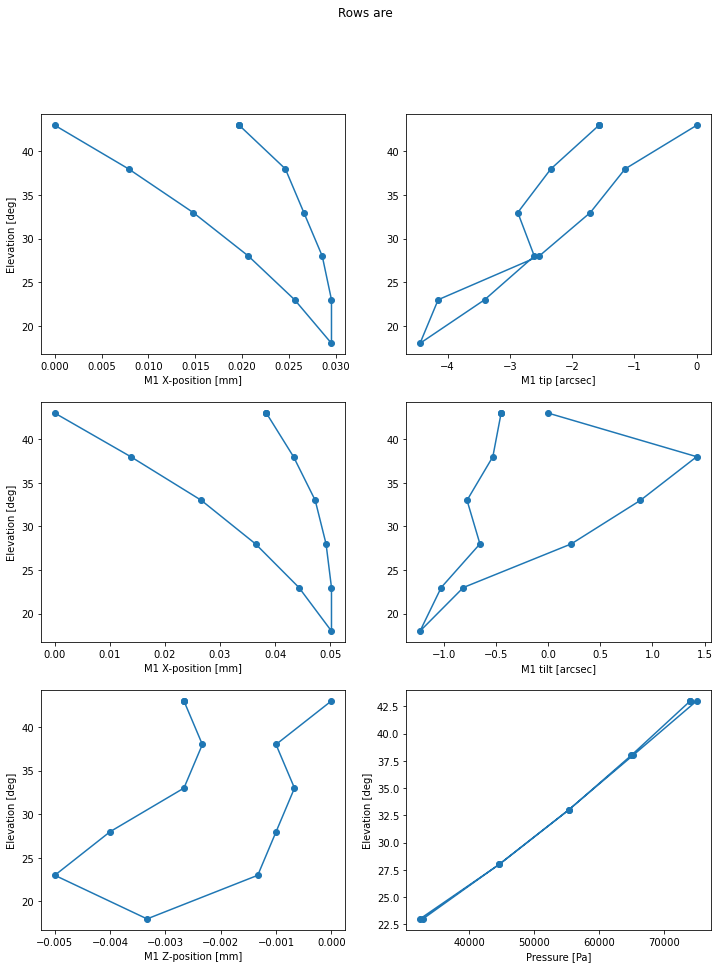

In [118]:
fig_height=5
fig_width=10
nwide=2; nhigh=3
fig, (row1,row2,row3) = plt.subplots(nhigh, nwide, figsize=(nwide+fig_width, nhigh*fig_height))
fig.suptitle('Rows are')
xvals = (calc_data.m1_x_pos) # um
yvals = calc_data.elevationCalculatedAngle1

row1[0].plot(xvals, yvals, 'o-')
row1[0].set_ylabel('Elevation [deg]')
row1[0].set_xlabel('M1 X-position [mm]')

xvals = (calc_data.m1_tip) # um
row1[1].plot(xvals, yvals, 'o-')
row1[1].set_xlabel('M1 tip [arcsec]')

xvals = (calc_data.m1_y_pos) # mm
row2[0].plot(xvals, yvals, 'o-')
row2[0].set_ylabel('Elevation [deg]')
row2[0].set_xlabel('M1 X-position [mm]')

xvals = (calc_data.m1_tilt) # um
row2[1].plot(xvals, yvals, 'o-')
row2[1].set_xlabel('M1 tilt [arcsec]')

xvals = (calc_data.m1_piston) # mm
row3[0].plot(xvals, yvals, 'o-')
row3[0].set_ylabel('Elevation [deg]')
row3[0].set_xlabel('M1 Z-position [mm]')

xvals = (calc_data.pressure) # mm
row3[1].plot(xvals, yvals, 'o-')
row3[1].set_ylabel('Elevation [deg]')
row3[1].set_xlabel('Pressure [Pa]')

In [ ]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     hex_elevation

# Now overplot the datasets

In [ ]:
# import itertools
# import matplotlib.cm as cm
# from matplotlib import colors
# runs = ['initial','test3b','test4b','test5b','test6','test7','test8','test9','test10','test11','test12','test13','test14','test15']
# #sym= ['.-','x-','triangle_up-']

# marker = itertools.cycle((',-', '+--', 'x-', 'v-', '*-')) 
# #colors=['red','blue','green']
# colors = cm.rainbow(np.linspace(0, 1, len(runs)))
# df={}

# scale_factors={'run':[], 'scale_factor':[]}
# fig_height=10
# fig_width=20

# %matplotlib inline

# nwide=3; nhigh=2
# fig, (row1,row2) = plt.subplots(nhigh, nwide, figsize=(nwide+fig_width, nhigh*fig_height))
# #fig.suptitle('Rows are')

# for i,r in enumerate(runs):
#     filename=date+'_'+test+"_"+r+"_metadata.csv"
# #     print(filename)
#     df[r] = pd.read_csv(filename, index_col=0)
#     df[r].index=pd.to_datetime(df[r].index)
#     # drop duplicates, not sure why there are double logs..
#     df[r].drop_duplicates(subset=['elevationCalculatedAngle1','message','pressure'])

#     if r =='initial':
#         starting_pressure = df[r].pressure[0]

#     scale_factor = 1-(df[r].pressure[0]-starting_pressure)/starting_pressure
#     scale_factors['run'].append(r)
#     scale_factors['scale_factor'].append(scale_factor)

# #     print(f'ratio is {scale_factor:0.3f} for {r}')
    
#     xvals = (df[r].m1_x_pos) # um
#     yvals = df[r].elevationCalculatedAngle1
#     sym=next(marker)
#     label = f'{r} {scale_factor:0.3f}'
#     color=colors[i]
#     row1[0].plot(xvals, yvals, sym, color=color, label=label)
#     row1[0].set_ylabel('Elevation [deg]')
#     row1[0].set_xlabel('M1 X-position [mm]')
    
#     xvals = (df[r].m1_y_pos) # mm
#     row1[1].plot(xvals, yvals, sym, color=color, label=label)
#     row1[1].set_ylabel('Elevation [deg]')
#     row1[1].set_xlabel('M1 Y-position [mm]')

#     xvals = (df[r].m1_piston) # mm
#     row1[2].plot(xvals, yvals, sym, color=color, label=label)
#     row1[2].set_ylabel('Elevation [deg]')
#     row1[2].set_xlabel('M1 Z-position [mm]')

#     row1[2].legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
    
#     xvals = (df[r].m1_tip) # um   - Tip should mean azimuth motion
#     row2[0].plot(xvals, yvals, sym, color=color, label=label)
#     row2[0].set_xlabel('M1 tip [arcsec]')
#     row2[0].legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
    
#     xvals = (df[r].m1_tilt) # um
#     row2[1].plot(xvals, yvals, sym, color=color, label=label)
#     row2[1].set_xlabel('M1 tilt [arcsec]')

#     xvals = (df[r].pressure) # um   - Tip should mean azimuth motion
#     row2[2].plot(xvals, yvals, sym, color=color, label=label)
#     row2[2].set_xlabel('Pressure [Pa]')

In [ ]:
tmp1 = rendezvous_dataframes(pressure, el)
tmp = rendezvous_dataframes(tmp1,atpneumatics_commands)
xvals=tmp['elevationCalculatedAngle1']
yvals=tmp['pressure']
plt.plot(xvals, yvals, '.')
yvals=tmp['pressure_cmd_atpneumatics']
plt.plot(xvals, yvals, '-', color='orange')
plt.ylabel('Elevation [deg]')
plt.xlabel('Pressure [Pa]')

In [ ]:
tmp

In [ ]:
atpneumatics_commands